In [1]:
#import dataset
from google.colab import files
uploaded = files.upload()

Saving preprocessed.csv to preprocessed.csv


In [2]:
#import library for preprocessing data
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.0 MB/s 


In [3]:
#labeling column
df = pd.read_csv('/content/preprocessed.csv', index_col=0)
df.head()

,tweet,label
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung te...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh jadi mahasiswa jangan sombong dong kasih...,negative
4,makan agam harga makan di food stall akan tam...,positive


In [ ]:
def preprocess(sentence):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = word_tokenize(sentence)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)
df['tweet'] = df['tweet'].apply(preprocess)

In [4]:
df.isnull().sum()

tweet    0
label    0
dtype: int64

In [5]:
df['tweet'] = df['tweet'].astype(str)

In [6]:
def cleaning(tweet):
  
  string = tweet.lower()
  string = re.sub(r'[^a-zA-Z]+', ' ', string)
  string = re.sub('0-9', ' ', string)
  
  return string
df['tweet'] = df['tweet'].apply(cleaning)

In [7]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
reader = df['tweet']
factory = StopWordRemoverFactory()
stopwords = factory.create_stop_word_remover()
df['tweet'] = df['tweet'].apply(stopwords.remove)

In [8]:
from nltk.corpus import stopwords as stopwords_scratch

list_sw = stopwords_scratch.words('indonesian')
list_sw_en = stopwords_scratch.words('english')
list_sw.extend(list_sw_en)
list_sw.extend(['ya', 'yuk', 'dah', 'yah', 'pa', 'ai', 'sepe', 'sih'])
stopwords = list_sw

In [9]:
df.tweet.duplicated().sum()

200

In [10]:
df['tweet'] = df['tweet'].drop_duplicates()

In [11]:
df.label.value_counts()

positive    6415
negative    3436
neutral     1148
Name: label, dtype: int64

In [12]:
df['tweet'] = df['tweet'].astype(str)

In [13]:
category = pd.get_dummies(df.label)
df_new = pd.concat([df, category], axis= 1)
df_new = df_new.drop(columns='label')
df_new

,tweet,negative,neutral,positive
0,mohon ulama lurus k mmbri hujjah partai apa ha...,0,1,0
1,lokasi strategis jalan sumatera bandung tempat...,0,0,1
2,betapa bahagia nya diri saat unboxing paket ba...,0,0,1
3,duh jadi mahasiswa jangan sombong dong kasih k...,1,0,0
4,makan agam harga makan food stall tambah di ka...,0,0,1
...,...,...,...,...
10994,nan,0,0,1
10995,enak rasa masakan nya kepiting senang pilih ke...,0,0,1
10996,nan,0,1,0
10997,pagi pagi tol pasteur macet parah bikin jengke...,1,0,0


In [14]:
sentimen = df_new['tweet'].values
label = df_new[['negative', 'neutral', 'positive']].values

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stopwords)
X = tfidf.fit_transform(df_new.tweet.to_list())

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Model LSTM TF

In [16]:
#import library model 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

In [18]:
X_latih, X_test, y_latih, y_test = train_test_split(sentimen, label, test_size=0.2, random_state=42, shuffle=True, stratify = label)
print('Training dataset:\n', X_latih.shape, y_latih.shape)
print('\nTest dataset:\n', X_test.shape, y_test.shape)

Training dataset:
 (8799,) (8799, 3)

Test dataset:
 (2200,) (2200, 3)


In [19]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'x'
training_portion = .8

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_latih)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'x': 767,
 'nya': 2,
 'makan': 3,
 'enak': 4,
 'tempat': 5,
 'rasa': 6,
 'sangat': 7,
 'harga': 8,
 'sini': 9,
 'menu': 10}

In [21]:
sekuens_train = tokenizer.texts_to_sequences(X_latih)
train_padded = pad_sequences(sekuens_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
sekuens_test = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(sekuens_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 390,275
Trainable params: 390,275
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.85):
      print("good enough")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
num_epochs = 5
history = model.fit(train_padded,
                    y_latih,
                    epochs=num_epochs,
                    validation_data=(test_padded, y_test),
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/5
275/275 - 62s - loss: 0.5707 - accuracy: 0.7653 - val_loss: 0.3896 - val_accuracy: 0.8482 - 62s/epoch - 225ms/step
Epoch 2/5
275/275 - 60s - loss: 0.2930 - accuracy: 0.8896 - val_loss: 0.3349 - val_accuracy: 0.8732 - 60s/epoch - 218ms/step
Epoch 3/5
good enough
275/275 - 57s - loss: 0.1991 - accuracy: 0.9276 - val_loss: 0.3692 - val_accuracy: 0.8764 - 57s/epoch - 206ms/step


       loss  accuracy  val_loss  val_accuracy
0  0.570747  0.765314  0.389619      0.848182
1  0.293016  0.889647  0.334908      0.873182
2  0.199074  0.927605  0.369161      0.876364


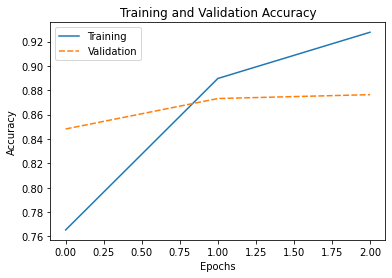

In [33]:
# Create pandas DataFrame
df_history = pd.DataFrame(history.history)
print(df_history)

my_plot = sns.lineplot(data=df_history[["accuracy","val_accuracy"]])
my_plot.set_xlabel('Epochs')
my_plot.set_ylabel('Accuracy')
plt.legend(labels=["Training", "Validation"], loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show();

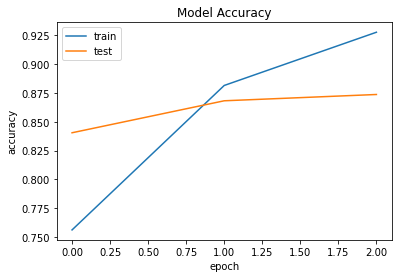

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

       loss  accuracy  val_loss  val_accuracy
0  0.570747  0.765314  0.389619      0.848182
1  0.293016  0.889647  0.334908      0.873182
2  0.199074  0.927605  0.369161      0.876364


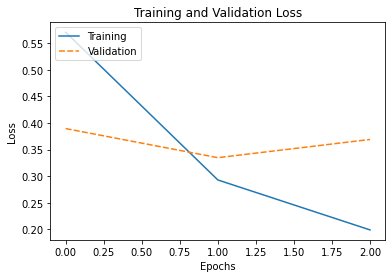

In [30]:
# Create pandas DataFrame
df_history = pd.DataFrame(history.history)
print(df_history)
 
# Plot using Seaborn
my_plot = sns.lineplot(data=df_history[["loss","val_loss"]])
my_plot.set_xlabel('Epochs')
my_plot.set_ylabel('Loss')
plt.legend(labels=["Training", "Validation"], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

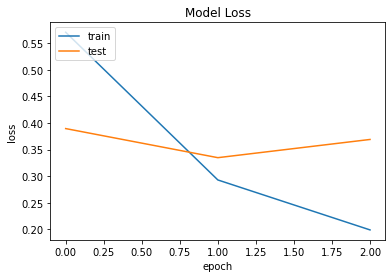

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

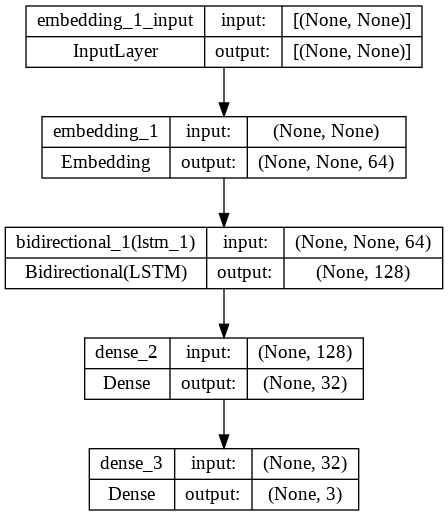

In [ ]:
import pydot
import graphviz
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.save('lstmmodelrenewal.h5')

In [ ]:
loss, acc = model.evaluate(x=test_padded, y=y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

69/69 - 3s - loss: 0.3533 - accuracy: 0.8736 - 3s/epoch - 50ms/step
Restored model, accuracy: 87.36%


In [ ]:
pred = model.predict(test_padded)
y_pred = pred
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('done testing')
print(matrix_test)

69/69 [==============================] - 4s 55ms/step
done testing
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       687
           1       0.86      0.72      0.79       230
           2       0.91      0.93      0.92      1283

    accuracy                           0.87      2200
   macro avg       0.86      0.82      0.84      2200
weighted avg       0.87      0.87      0.87      2200



In [ ]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
accuracies=[]

y = y_test
embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(test_padded), start=1):
  data_test = test_padded[0]
  target_test = y_test

  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.85):
        print("good enough")
        self.model.stop_training = True
  callbacks = myCallback()

  history = model.fit(train_padded,
                    y_latih,
                    epochs=5,
                    validation_data=(test_padded, y_test),
                    verbose=0,
                    callbacks=[callbacks])
  
  pred = model.predict(test_padded)
  y_pred = pred

  accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  print('perulangan ke-', iteration)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
  print('---------------------------------------------------------------')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print('akurasi sebesar:', average_accuracy)

good enough
69/69 [==============================] - 5s 56ms/step
perulangan ke- 1
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       687
           1       0.84      0.79      0.81       230
           2       0.89      0.94      0.91      1283

    accuracy                           0.87      2200
   macro avg       0.86      0.84      0.85      2200
weighted avg       0.87      0.87      0.87      2200

---------------------------------------------------------------
good enough
69/69 [==============================] - 5s 56ms/step
perulangan ke- 2
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       687
           1       0.67      0.87      0.76       230
           2       0.89      0.93      0.91      1283

    accuracy                           0.86      2200
   macro avg       0.82      0.84      0.82      2200
weighted avg       0.87      0.86      0.86      2200

--------

In [ ]:
tweet = ['rasa syukur, cukuppp']
seq = tokenizer.texts_to_sequences(tweet)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['negative', 'neutral', 'positive']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 42ms/step
[[0.434168   0.11892369 0.4469083 ]] positive
